In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
#from tensorflow.keras.models import *
#from tensorflow.keras.layers import *
from tensorflow.keras.layers import *

print('Tensorflow: {}'.format(tf.__version__))

import matplotlib.pyplot as plt
plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

tf.config.list_physical_devices('GPU')

from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)

#%run pre_processing.ipyn

Tensorflow: 2.1.0
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5



In [2]:
hyp_par_len = 90

# Get the Data from a saved CSV.

In [3]:

cvs_path = (r'C:\Users\Josh\Documents\4th Year Docs\Dist+Con\CA Group\Stockcsvs\AAPL_daily.csv')

df = pd.read_csv(cvs_path, delimiter=',', usecols=['date', '1. open', '2. high', '3. low', '4. close', '5. volume'])

# 0 values cause division error
df['5. volume'].replace(to_replace=0, method='ffill', inplace=True) 
df.sort_values('date', inplace=False)
df.tail()

df[['1. open', '2. high', '3. low', '4. close', '5. volume']] = df[['1. open', '2. high', '3. low', '4. close', '5. volume']].rolling(12).mean()

df.dropna(how='any', axis=0, inplace=True)

df.head

<bound method NDFrame.head of             date     1. open     2. high      3. low    4. close     5. volume
11    2021-01-12  134.415000  136.563683  132.519000  134.730833  1.125359e+08
12    2021-01-11  133.554167  135.578683  131.835667  134.055000  1.090358e+08
13    2021-01-08  132.637500  134.606183  130.987333  133.220833  1.060620e+08
14    2021-01-07  131.367500  133.550350  129.861500  132.200833  1.069943e+08
15    2021-01-06  130.088333  132.380342  129.015000  130.840833  1.067840e+08
...          ...         ...         ...         ...         ...           ...
5340  1999-11-05   90.095000   92.798333   88.071667   91.014167  3.751292e+06
5341  1999-11-04   89.287500   92.266667   87.352500   90.430833  3.882783e+06
5342  1999-11-03   88.630833   91.465000   86.764167   89.519167  3.894650e+06
5343  1999-11-02   87.542500   90.679167   85.836667   88.738333  3.920283e+06
5344  1999-11-01   86.651667   89.507500   84.784167   87.685833  3.856300e+06

[5334 rows x 6 column

# Visualise the Data

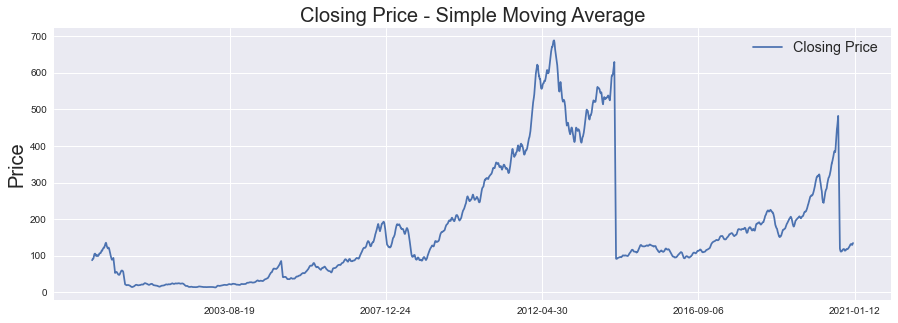

In [4]:
#Plot Closing Price
plt.figure(figsize=(15, 5))
plt.plot(df['4. close'])
plt.xticks(range(0, df.shape[0], 1095), df['date'].loc[::1095], rotation=0)
plt.ylabel('Price', fontsize=20)
plt.title("Closing Price - Simple Moving Average", fontsize=20)
plt.legend(['Closing Price'], fontsize='x-large', loc='best')
plt.gca().invert_xaxis()
plt.show()

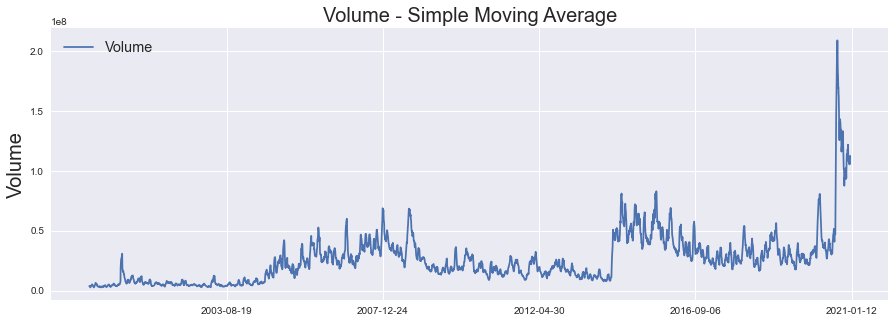

In [5]:
#Plot Volume
plt.figure(figsize=(15, 5))
plt.plot(df['5. volume'])
plt.xticks(range(0, df.shape[0], 1095), df['date'].loc[::1095], rotation=0)
plt.ylabel('Volume', fontsize=20)
plt.title("Volume - Simple Moving Average", fontsize=20)
plt.legend(['Volume'], fontsize='x-large', loc='best')
plt.gca().invert_xaxis()
plt.show()

# Normalise the Data

In [6]:
#Calculate the normalised percentage change in each column

df['1. open'] = df['1. open'].pct_change()
df['2. high'] = df['2. high'].pct_change()
df['3. low'] = df['3. low'].pct_change()
df['4. close'] = df['4. close'].pct_change()
df['5. volume'] = df['5. volume'].pct_change()

df.dropna(how='any', axis=0, inplace=True)

#Price
min_ret = min(df[['1. open', '2. high', '3. low', '4. close']].min(axis=0))
max_ret = max(df[['1. open', '2. high', '3. low', '4. close']].max(axis=0))

df['1. open'] = (df['1. open'] - min_ret) / (max_ret - min_ret)
df['2. high'] = (df['2. high'] - min_ret) / (max_ret - min_ret)
df['3. low'] = (df['3. low'] - min_ret) / (max_ret - min_ret)
df['4. close'] = (df['4. close'] - min_ret) / (max_ret - min_ret)

#Volume
min_volume = df['5. volume'].min(axis=0)
max_volume = df['5. volume'].max(axis=0)

df['5. volume'] = (df['5. volume'] - min_volume) / (max_volume - min_volume)

# Split the Data in to Training, Validation and Testing

In [7]:
#Split data into training, validation and test subsets
times = sorted(df.index.values)
last_15pct = sorted(df.index.values)[-int(0.15*len(times))]
last_30pct = sorted(df.index.values)[-int(0.30*len(times))]

df_training = df[(df.index < last_30pct)]
df_validation = df[(df.index >= last_30pct) & (df.index < last_15pct)]
df_test = df[(df.index >= last_15pct)]

#date gets removed
df_training.drop(columns=['date'], inplace=True)
df_validation.drop(columns=['date'], inplace=True)
df_test.drop(columns=['date'], inplace=True)

#Make arrays
train_data = df_training.values
val_data = df_validation.values
test_data = df_test.values
print('Training shape: {}'.format(train_data.shape))
print('Validation shape: {}'.format(val_data.shape))
print('Test shape: {}'.format(test_data.shape))

df_training.head()

Training shape: (3734, 5)
Validation shape: (800, 5)
Test shape: (799, 5)


,1. open,2. high,3. low,4. close,5. volume
12,0.040982,0.039464,0.043325,0.043589,0.505155
13,0.040119,0.039538,0.040925,0.041323,0.508751
14,0.035027,0.038278,0.036868,0.038630,0.542637
15,0.034722,0.036556,0.040767,0.033689,0.532531
16,0.044119,0.043421,0.045015,0.043368,0.522063


# Visualise Daily Changes

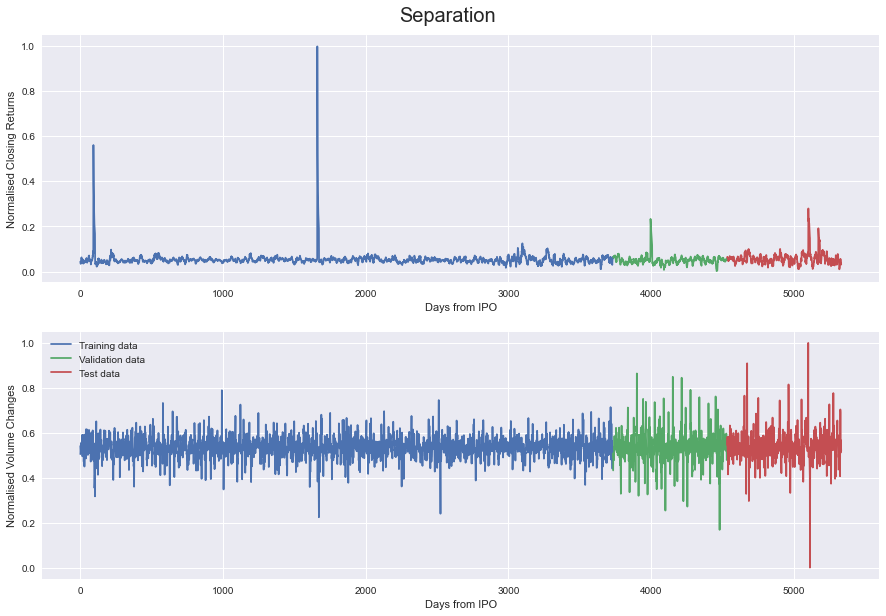

In [8]:
#Closing price and Volume daily changes
figure = plt.figure(figsize=(15,10))
suptitle = figure.suptitle("Separation", fontsize=20)
suptitle.set_y(0.92)


ax1 = figure.add_subplot(211)
ax1.plot(np.arange(train_data.shape[0]), df_training['4. close'], label='Training data')

ax1.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_validation['4. close'], label='Validation data')

ax1.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['4. close'], label='Test data')
ax1.set_xlabel('Days from IPO')
ax1.set_ylabel('Normalised Closing Returns')


ax2 = figure.add_subplot(212)
ax2.plot(np.arange(train_data.shape[0]), df_training['5. volume'], label='Training data')

ax2.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_validation['5. volume'], label='Validation data')

ax2.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['5. volume'], label='Test data')
ax2.set_xlabel('Days from IPO')
ax2.set_ylabel('Normalised Volume Changes')

plt.legend(loc='best')

In [9]:
#Split into subsections of data for efficiency and specific tuning
#Trasining
X_training, y_training = [], []
for i in range(hyp_par_len, len(train_data)):
  X_training.append(train_data[i-hyp_par_len:i])
  y_training.append(train_data[:, 3][i]) 
X_training, y_training = np.array(X_training), np.array(y_training)

# Validation
X_validation, y_validation = [], []
for i in range(hyp_par_len, len(val_data)):
    X_validation.append(val_data[i-hyp_par_len:i])
    y_validation.append(val_data[:, 3][i])
X_validation, y_validation = np.array(X_validation), np.array(y_validation)

# Test
X_test, y_test = [], []
for i in range(hyp_par_len, len(test_data)):
    X_test.append(test_data[i-hyp_par_len:i])
    y_test.append(test_data[:, 3][i])    
X_test, y_test = np.array(X_test), np.array(y_test)

print(X_training.shape, y_training.shape)
print(X_validation.shape, y_validation.shape)


(3644, 90, 5) (3644,)
(710, 90, 5) (710,)


# Create LSTM Model

In [10]:
def LSTM_model():
  sequence = Input(shape = (hyp_par_len, 5))
      
  x =  Bidirectional(LSTM(128, return_sequences=True))(sequence)
  x =  Bidirectional(LSTM(128, return_sequences=True))(x)
  x =  Bidirectional(LSTM(64, return_sequences=True))(x) 

#Pooling
  avg_pooling = GlobalAveragePooling1D()(x)
  max_pooling = GlobalMaxPooling1D()(x)
  addPools = concatenate([avg_pooling, max_pooling])
    
#Linear Activation Function
  addPools = Dense(64, activation="relu")(addPools)
  out = Dense(1, activation="sigmoid")(addPools)      

  lstm = tf.keras.Model(inputs=sequence, outputs=out)
  lstm.compile(loss="mse", optimizer="adam", metrics=['mae', 'mape'])

#Draw model
#  dot_img_file = r'C:\Users\Josh\Documents\4th Year Docs\Dist+Con\CA Group\model_1.png'
#  tf.keras.utils.plot_model(lstm, to_file=dot_img_file, show_shapes=True)
  return lstm

#Run model
lstm = LSTM_model()

callback = tf.keras.callbacks.ModelCheckpoint('BI-LSTM.hdf5', monitor='val_loss', save_best_only=True, verbose=1)

# Begin Training of Model

In [11]:
lstm.fit(X_training, y_training,
              batch_size=1024,
              verbose=2,
              callbacks=[callback],
              epochs=200,
              validation_data=(X_validation, y_validation),)    

Train on 3644 samples, validate on 710 samples
Epoch 1/200

Epoch 00001: val_loss improved from inf to 0.00168, saving model to BI-LSTM.hdf5
3644/3644 - 10s - loss: 0.1197 - mae: 0.3295 - mape: 680.8155 - val_loss: 0.0017 - val_mae: 0.0381 - val_mape: 112.0401
Epoch 2/200

Epoch 00002: val_loss did not improve from 0.00168
3644/3644 - 1s - loss: 0.0019 - mae: 0.0322 - mape: 61.0833 - val_loss: 0.0022 - val_mae: 0.0422 - val_mape: 83.8852
Epoch 3/200

Epoch 00003: val_loss did not improve from 0.00168
3644/3644 - 1s - loss: 0.0031 - mae: 0.0473 - mape: 88.5035 - val_loss: 0.0024 - val_mae: 0.0448 - val_mape: 89.3260
Epoch 4/200

Epoch 00004: val_loss did not improve from 0.00168
3644/3644 - 1s - loss: 0.0032 - mae: 0.0479 - mape: 89.8755 - val_loss: 0.0022 - val_mae: 0.0423 - val_mape: 84.0941
Epoch 5/200

Epoch 00005: val_loss improved from 0.00168 to 0.00115, saving model to BI-LSTM.hdf5
3644/3644 - 1s - loss: 0.0027 - mae: 0.0428 - mape: 79.2403 - val_loss: 0.0011 - val_mae: 0.0274 -


Epoch 00043: val_loss did not improve from 0.00043
3644/3644 - 1s - loss: 9.0181e-04 - mae: 0.0102 - mape: 18.4376 - val_loss: 4.3433e-04 - val_mae: 0.0122 - val_mape: 40.2999
Epoch 44/200

Epoch 00044: val_loss did not improve from 0.00043
3644/3644 - 1s - loss: 9.0315e-04 - mae: 0.0105 - mape: 19.5768 - val_loss: 4.4723e-04 - val_mae: 0.0127 - val_mape: 42.7632
Epoch 45/200

Epoch 00045: val_loss did not improve from 0.00043
3644/3644 - 1s - loss: 9.0185e-04 - mae: 0.0102 - mape: 18.5620 - val_loss: 4.3242e-04 - val_mae: 0.0121 - val_mape: 39.8270
Epoch 46/200

Epoch 00046: val_loss did not improve from 0.00043
3644/3644 - 1s - loss: 9.0211e-04 - mae: 0.0104 - mape: 19.1038 - val_loss: 4.4890e-04 - val_mae: 0.0127 - val_mape: 43.0456
Epoch 47/200

Epoch 00047: val_loss did not improve from 0.00043
3644/3644 - 1s - loss: 8.9985e-04 - mae: 0.0104 - mape: 19.1227 - val_loss: 4.3598e-04 - val_mae: 0.0122 - val_mape: 40.7022
Epoch 48/200

Epoch 00048: val_loss did not improve from 0.0004

Epoch 86/200

Epoch 00086: val_loss improved from 0.00042 to 0.00042, saving model to BI-LSTM.hdf5
3644/3644 - 1s - loss: 8.7004e-04 - mae: 0.0103 - mape: 19.0760 - val_loss: 4.1594e-04 - val_mae: 0.0118 - val_mape: 37.0317
Epoch 87/200

Epoch 00087: val_loss did not improve from 0.00042
3644/3644 - 1s - loss: 8.9877e-04 - mae: 0.0109 - mape: 19.8695 - val_loss: 4.2599e-04 - val_mae: 0.0119 - val_mape: 36.2124
Epoch 88/200

Epoch 00088: val_loss did not improve from 0.00042
3644/3644 - 1s - loss: 9.0027e-04 - mae: 0.0106 - mape: 18.8936 - val_loss: 5.0231e-04 - val_mae: 0.0148 - val_mape: 50.3329
Epoch 89/200

Epoch 00089: val_loss did not improve from 0.00042
3644/3644 - 1s - loss: 9.0591e-04 - mae: 0.0109 - mape: 20.2451 - val_loss: 4.2303e-04 - val_mae: 0.0118 - val_mape: 37.7696
Epoch 90/200

Epoch 00090: val_loss did not improve from 0.00042
3644/3644 - 1s - loss: 9.0515e-04 - mae: 0.0110 - mape: 20.7769 - val_loss: 4.3625e-04 - val_mae: 0.0124 - val_mape: 41.6407
Epoch 91/200

Ep

Epoch 129/200

Epoch 00129: val_loss did not improve from 0.00035
3644/3644 - 1s - loss: 8.7294e-04 - mae: 0.0101 - mape: 18.6345 - val_loss: 4.3606e-04 - val_mae: 0.0127 - val_mape: 43.2449
Epoch 130/200

Epoch 00130: val_loss did not improve from 0.00035
3644/3644 - 1s - loss: 8.7052e-04 - mae: 0.0102 - mape: 19.0315 - val_loss: 4.1976e-04 - val_mae: 0.0121 - val_mape: 40.6457
Epoch 131/200

Epoch 00131: val_loss did not improve from 0.00035
3644/3644 - 1s - loss: 8.6520e-04 - mae: 0.0101 - mape: 18.5329 - val_loss: 4.3212e-04 - val_mae: 0.0127 - val_mape: 43.3634
Epoch 132/200

Epoch 00132: val_loss did not improve from 0.00035
3644/3644 - 1s - loss: 8.6166e-04 - mae: 0.0103 - mape: 19.2164 - val_loss: 4.0941e-04 - val_mae: 0.0118 - val_mape: 38.8742
Epoch 133/200

Epoch 00133: val_loss did not improve from 0.00035
3644/3644 - 1s - loss: 8.5777e-04 - mae: 0.0100 - mape: 18.3999 - val_loss: 4.1290e-04 - val_mae: 0.0122 - val_mape: 41.1736
Epoch 134/200

Epoch 00134: val_loss did not 

Epoch 172/200

Epoch 00172: val_loss did not improve from 0.00034
3644/3644 - 1s - loss: 0.0037 - mae: 0.0525 - mape: 99.2396 - val_loss: 0.0028 - val_mae: 0.0490 - val_mape: 99.3589
Epoch 173/200

Epoch 00173: val_loss did not improve from 0.00034
3644/3644 - 1s - loss: 0.0037 - mae: 0.0527 - mape: 99.5578 - val_loss: 0.0028 - val_mae: 0.0491 - val_mape: 99.5861
Epoch 174/200

Epoch 00174: val_loss did not improve from 0.00034
3644/3644 - 1s - loss: 0.0037 - mae: 0.0527 - mape: 99.6800 - val_loss: 0.0028 - val_mae: 0.0492 - val_mape: 99.6521
Epoch 175/200

Epoch 00175: val_loss did not improve from 0.00034
3644/3644 - 1s - loss: 0.0037 - mae: 0.0528 - mape: 99.7225 - val_loss: 0.0028 - val_mae: 0.0492 - val_mape: 99.6806
Epoch 176/200

Epoch 00176: val_loss did not improve from 0.00034
3644/3644 - 1s - loss: 0.0037 - mae: 0.0528 - mape: 99.7403 - val_loss: 0.0028 - val_mae: 0.0492 - val_mape: 99.6896
Epoch 177/200

Epoch 00177: val_loss did not improve from 0.00034
3644/3644 - 1s - lo

# Load Model

In [20]:
lstm = tf.keras.models.load_model(r'C:\Users\Josh\Documents\4th Year Docs\Dist+Con\CA Group\Bi-LSTM.hdf5')

# Evaluate Model

 
Metrics
Training - Loss: 0.0007, MAE: 0.0090, MAPE: 16.6178
Validation - Loss: 0.0003, MAE: 0.0113, MAPE: 37.6185
Test - Loss: 0.0006, MAE: 0.0159, MAPE: 31.8992


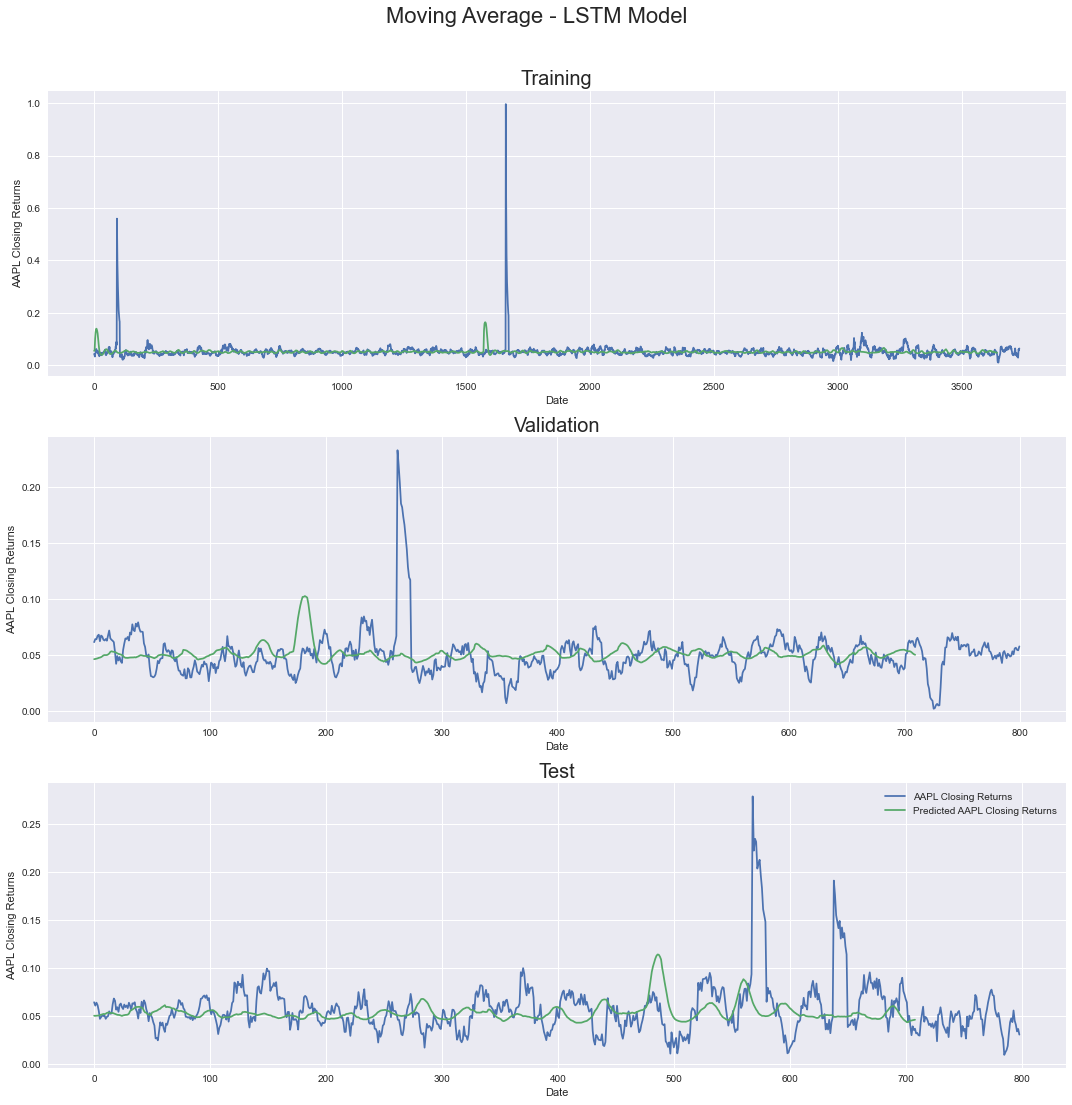

In [21]:
#Prdict
train_pred = lstm.predict(X_training)
val_pred = lstm.predict(X_validation)
test_pred = lstm.predict(X_test)

#Print evaluation metrics for all datasets
training_eval = lstm.evaluate(X_training, y_training, verbose=0)
validation_eval = lstm.evaluate(X_validation, y_validation, verbose=0)
test_eval = lstm.evaluate(X_test, y_test, verbose=0)
print(' ')
print('Metrics')
print('Training - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(training_eval[0], training_eval[1], training_eval[2]))
print('Validation - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(validation_eval[0], validation_eval[1], validation_eval[2]))
print('Test - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

#Plot results
figure = plt.figure(figsize=(15,15))
suptitle = figure.suptitle("Moving Average - LSTM Model", fontsize=22)
suptitle.set_y(1.02)

#training
ax11 = figure.add_subplot(311)
ax11.plot(train_data[:, 3], label='AAPL Closing Returns')
ax11.plot(train_pred, label='Predicted AAPL Closing Returns')
ax11.set_title("Training", fontsize=20)
ax11.set_xlabel('Date')
ax11.set_ylabel('AAPL Closing Returns')

#validation
ax21 = figure.add_subplot(312)
ax21.plot(val_data[:, 3], label='AAPL Closing Returns')
ax21.plot(val_pred, label='Predicted AAPL Closing Returns')
ax21.set_title("Validation", fontsize=20)
ax21.set_xlabel('Date')
ax21.set_ylabel('AAPL Closing Returns')

#test
ax31 = figure.add_subplot(313)
ax31.plot(test_data[:, 3], label='AAPL Closing Returns')
ax31.plot(test_pred, label='Predicted AAPL Closing Returns')
ax31.set_title("Test", fontsize=20)
ax31.set_xlabel('Date')
ax31.set_ylabel('AAPL Closing Returns')
 
plt.tight_layout()
plt.legend(loc='best')

ValueError: x and y must have same first dimension, but have shapes (5333,) and (4533, 5)

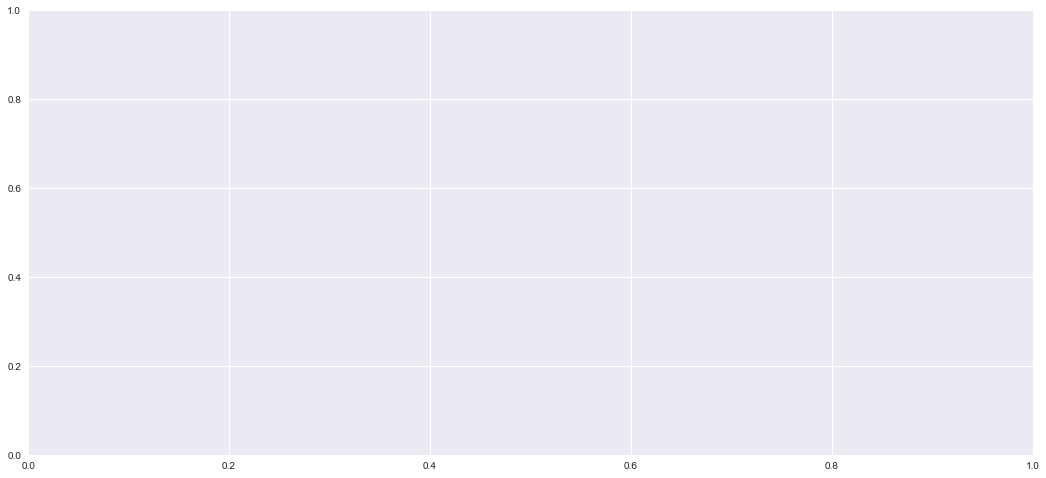

In [22]:
best_prediction_epoch = 147 # replace this with the epoch that you got the best results when running the plotting code

plt.figure(figsize = (18,18))
plt.subplot(2,1,1)
plt.plot(range(df.shape[0]),np.concatenate([df_training,df_test],axis=0),color='b')

# Plotting how the predictions change over time
# Plot older predictions with low alpha and newer predictions with high alpha
start_alpha = 0.25
alpha  = np.arange(start_alpha,1.1,(1.0-start_alpha)/len(200[::3]))
for p_i,p in enumerate(200[::3]):
    for xval,yval in zip(x_axis_seq,p):
        plt.plot(xval,yval,color='r',alpha=alpha[p_i])

plt.title('Evolution of Test Predictions Over Time',fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.xlim(11000,12500)

plt.subplot(2,1,2)

# Predicting the best test prediction you got
plt.plot(range(df.shape[0]),np.concatenate([df_training,df_test],axis=0),color='b')
for xval,yval in zip(x_axis_seq,200[best_prediction_epoch]):
    plt.plot(xval,yval,color='r')

plt.title('Best Test Predictions Over Time',fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.xlim(11000,12500)
plt.show()